## Import the Competition Data from Kaggle API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/Kaggle/P1-House-Price-Prediction')
!pwd

/content/drive/MyDrive/Projects/Kaggle/P1-House-Price-Prediction


In [ ]:
ls -la

total 941
-rw------- 1 root root  13370 Dec 25 05:05 data_description.txt
drwx------ 2 root root   4096 Dec 25 06:32 images/
-rw------- 1 root root     63 Dec 25 04:51 kaggle.json
-rw------- 1 root root  31939 Dec 25 05:05 sample_submission.csv
-rw------- 1 root root 451405 Dec 25 05:05 test.csv
-rw------- 1 root root 460676 Dec 25 05:05 train.csv


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teertha","key":"bee5a8292859699fb6106115af4f90e9"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

* <b>Reference</b>: [Kaggle API Documentation](https://github.com/Kaggle/kaggle-api)

In [ ]:
!kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
arashnic/hr-analytics-job-change-of-data-scientists          HR Analytics: Job Change of Data Scientists    295KB  2020-12-07 00:25:10            384  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           3374  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44          11550  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates           4KB  2020-11-26 00:21:15           3532  
afrniomelo/3w-dataset                                        3W Dataset - Undesirable ev

In [ ]:
!kaggle competitions list --category gettingStarted

ref                                          deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                 2030-07-01 23:59:00  Getting Started     Prizes         89           False  
gan-getting-started                          2030-07-01 23:59:00  Getting Started     Prizes        182           False  
tpu-getting-started                          2030-06-03 23:59:00  Getting Started  Knowledge        283           False  
digit-recognizer                             2030-01-01 00:00:00  Getting Started  Knowledge       2119           False  
titanic                                      2030-01-01 00:00:00  Getting Started  Knowledge      16788            True  
house-prices-advanced-regression-techniques  2030-01-01 00:00:00  Getting Started  Knowledge       4521            True  
connectx                

In [ ]:
!kaggle competitions download house-prices-advanced-regression-techniques



  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 4.29MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 28.5MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 1.77MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 20.9MB/s]


In [ ]:
ls -la

total 941
-rw------- 1 root root  13370 Dec 25 05:05 data_description.txt
drwx------ 2 root root   4096 Dec 25 06:32 images/
-rw------- 1 root root     63 Dec 25 04:51 kaggle.json
-rw------- 1 root root  31939 Dec 25 05:05 sample_submission.csv
-rw------- 1 root root 451405 Dec 25 05:05 test.csv
-rw------- 1 root root 460676 Dec 25 05:05 train.csv


In [ ]:
from IPython.display import Image
Image('images/Screenshot_1.png')

## Loading the Data and Libraries

In [ ]:
# Essentials
import os
import sys
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style("whitegrid");
sns.set_color_codes(palette='pastel');

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

pd.set_option('display.float_format', lambda x: '%.3f' % x);
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;

import warnings
warnings.filterwarnings(action="ignore");

In [ ]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

## Exploratory Data Analysis


### The Goal
* Each row in the dataset describes the characteristics of a house.
* Our goal is to predict the SalePrice, given these features.
* Our models will be evaluated on the Root-Mean-Squared-Error (RMSE) between the <b>log of the SalePrice predicted by our model</b>, and the <b>log of the actual SalePrice</b>. 
* Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.

In [ ]:
# Preview the train data 
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0     196.000        Gd        TA      PConc       Gd       TA           No   
1       0.000        TA        TA     CBlock       Gd       TA           Gd   
2     162.000        Gd        TA      PConc       Gd       TA           Mn   
3       0.000        TA        TA     BrkTil       TA       Gd           No   
4     350.000        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [ ]:
textfile = "data_description.txt"
with open(textfile, "r") as file:
    FileContent = file.read()
    print(FileContent)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Uni-variate Analysis
Let's analyze the distribution of 'SalePrice', our target attribute.      

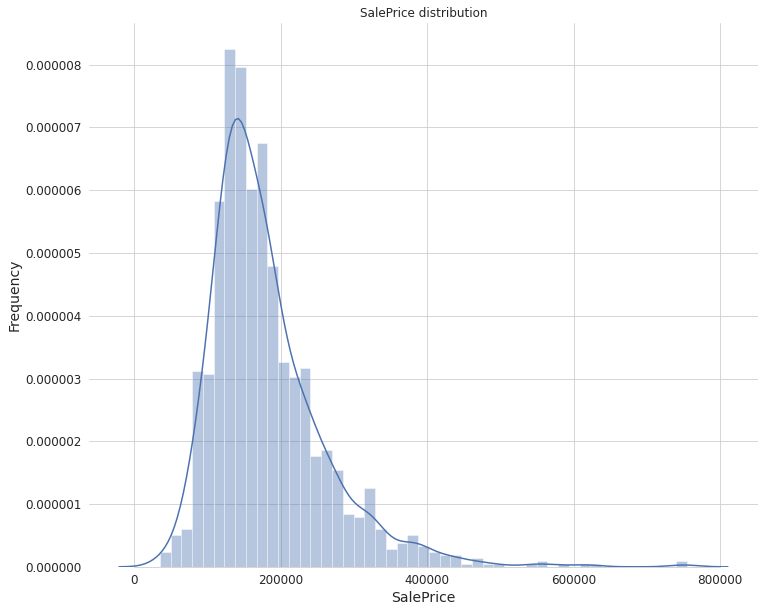

In [ ]:
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 10))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
plt.ticklabel_format(style='plain', axis='y')
# ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# Skewness and kurtosis
print("Skewness of SalePrice: %f" % train['SalePrice'].skew())
print("Kurtosis of SalePrice: %f" % train['SalePrice'].kurt())

Skewness of SalePrice: 1.882876
Kurtosis of SalePrice: 6.536282


In [ ]:
# find categorical variables
# categorical = []
categorical = [var for var in train.columns if train[var].dtype=='O']
print('There are {} categorical variables.'.format(len(categorical)))

There are 43 categorical variables.


In [ ]:
# find numerical variables
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables.'.format(len(numerical)))

There are 38 numerical variables.


Numerical variables can be a) binary, b) continuous or c) discrete. A priori, it is good practice to know what each variable means, to then be able to differentiate continuous from discrete variables. In this notebook, we will assume that variables with a definite and low number of unique values are discrete.

#### Finding discrete variables
To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values.

In [ ]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(train[var].unique())<20:
        print(var, ' values: ', train[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables.'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 15 discrete variables.


In [ ]:
# Let's make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice']]
print('There are {} continuous variables.'.format(len(continuous)))

There are 21 continuous variables.


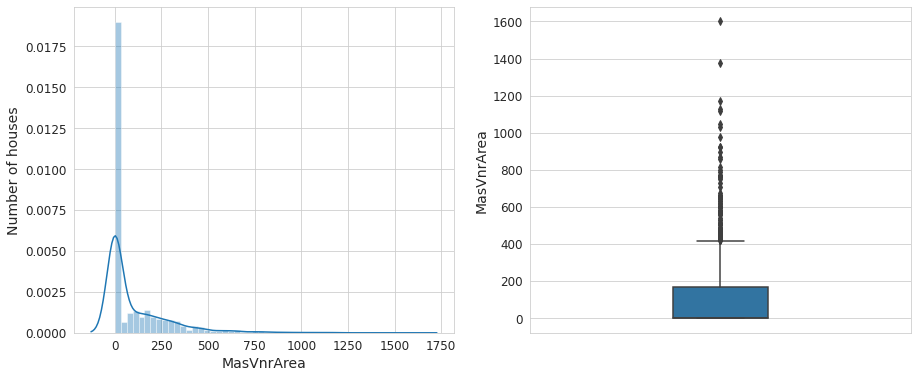

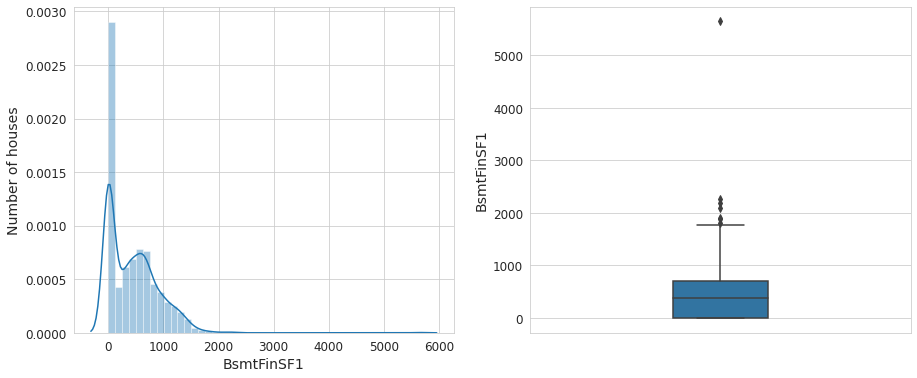

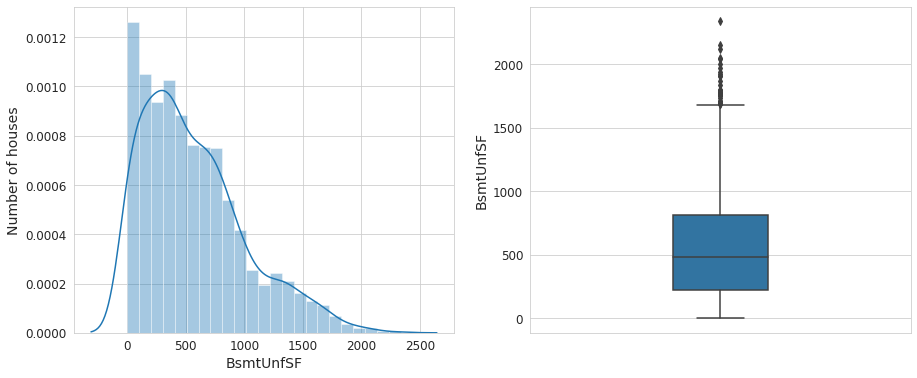

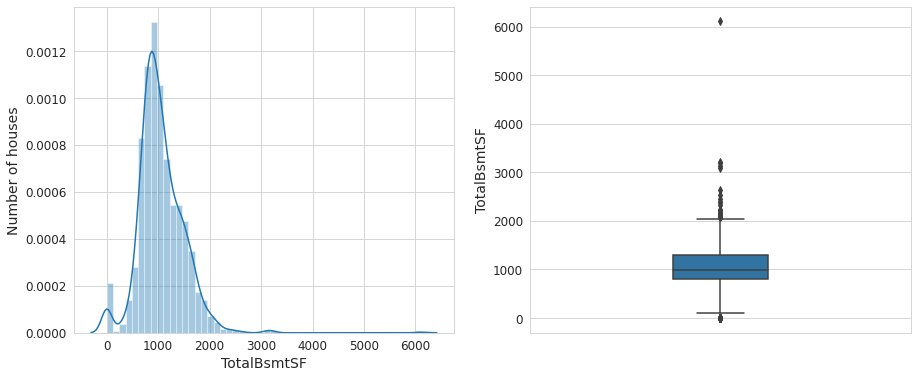

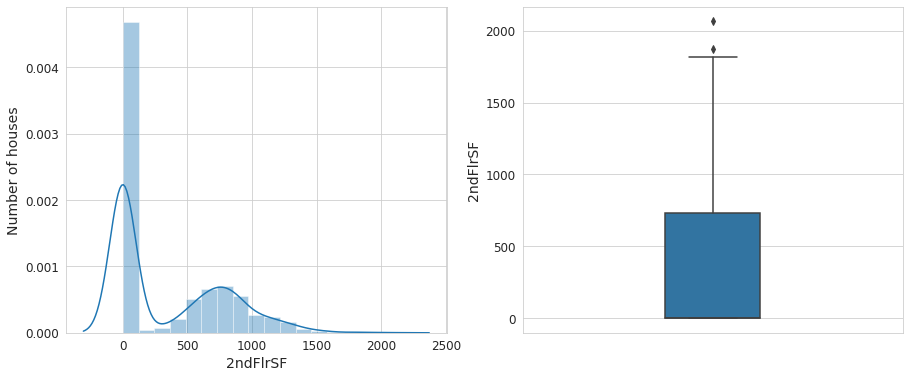

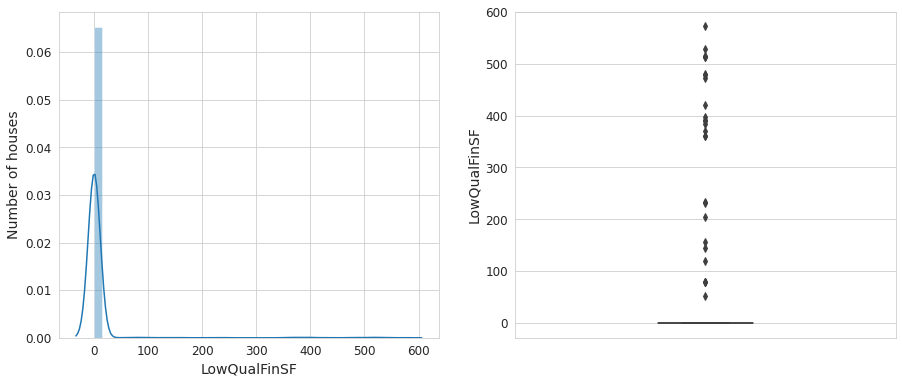

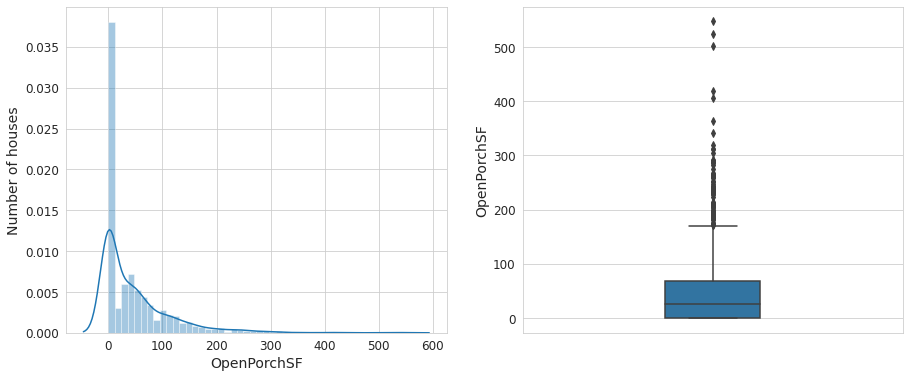

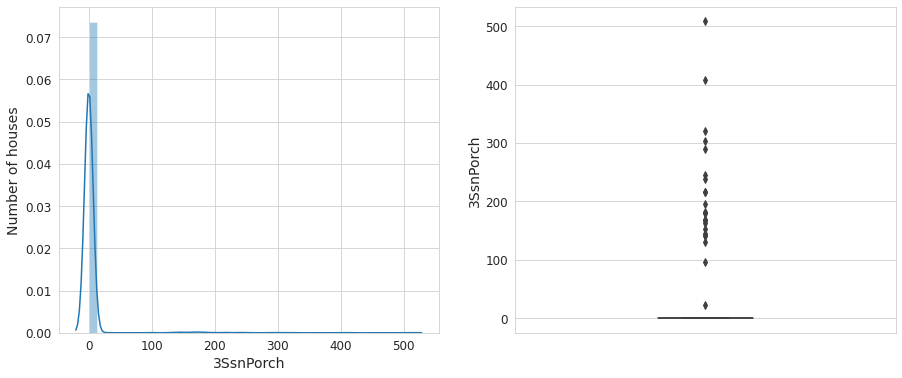

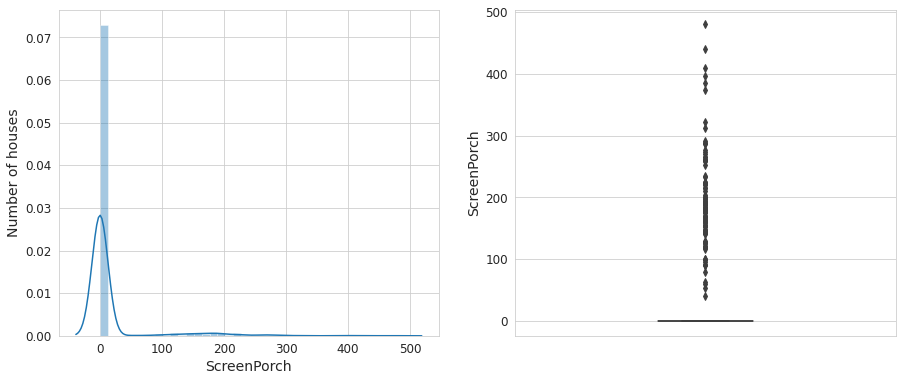

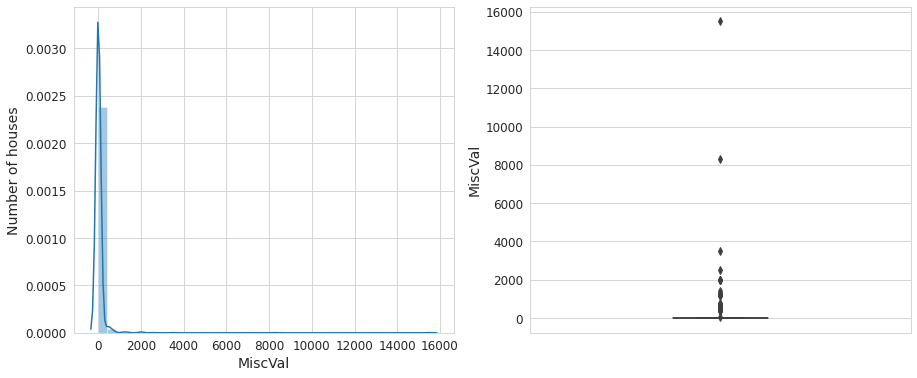

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(train[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.boxplot(y=train[var], width=0.25)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.show()

In [ ]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

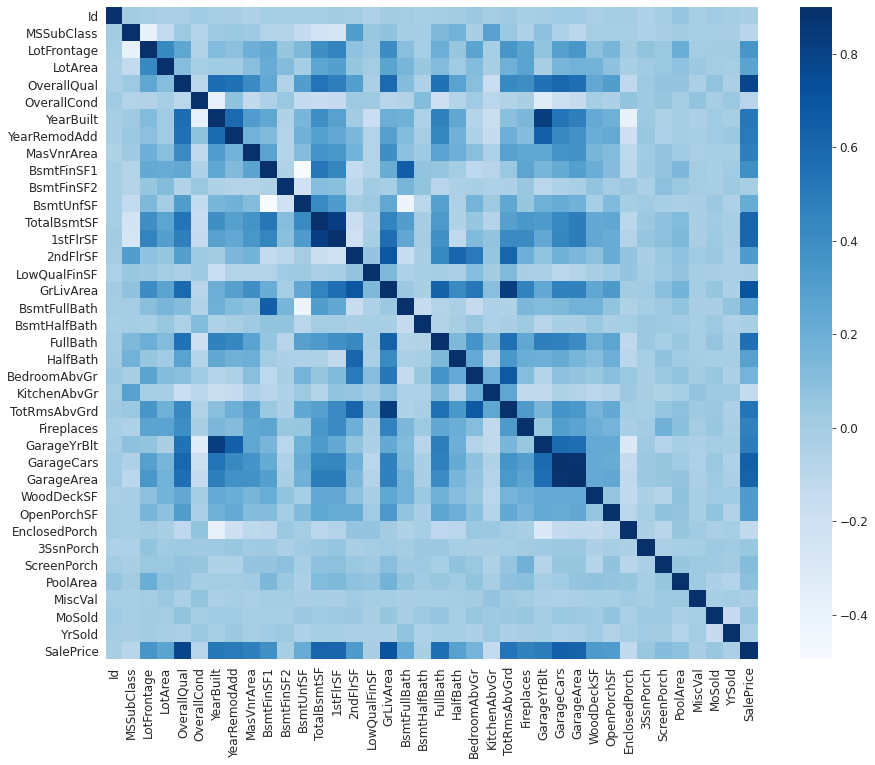

In [ ]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

### Pairwise Correlation
Let's plot how SalePrice relates to some of the features in the dataset.

In [ ]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

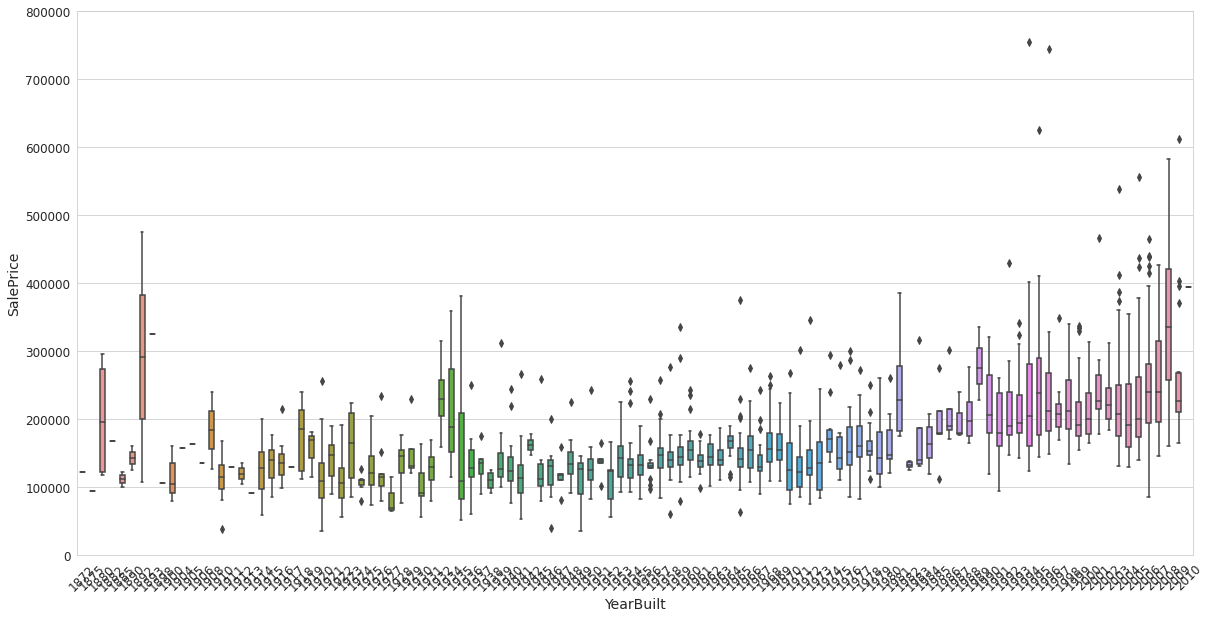

In [ ]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data, width = 0.5)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);

In [ ]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

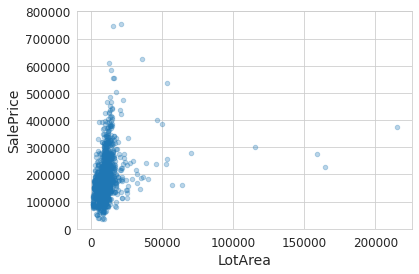

In [ ]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

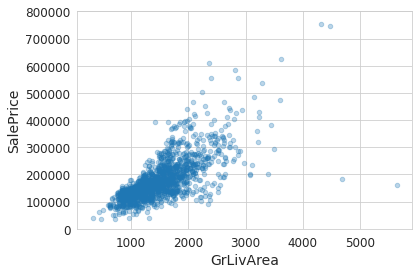

In [ ]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

## Feature Engineering

In [ ]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

Let's take a look at the distribution of the SalePrice.

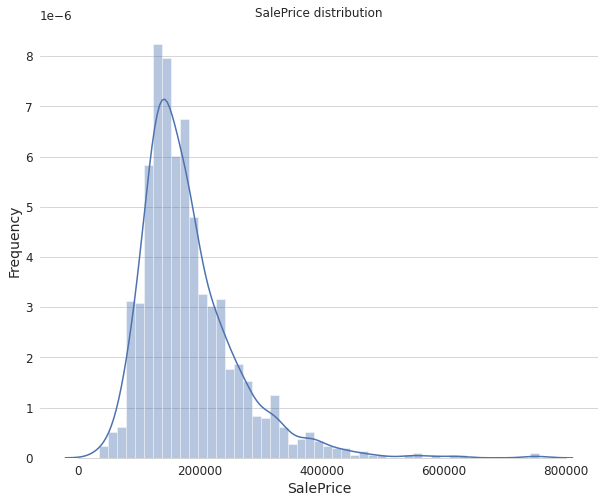

In [ ]:
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 8))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.



In [ ]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Let's plot the SalePrice again.


 mu = 12.02 and sigma = 0.40



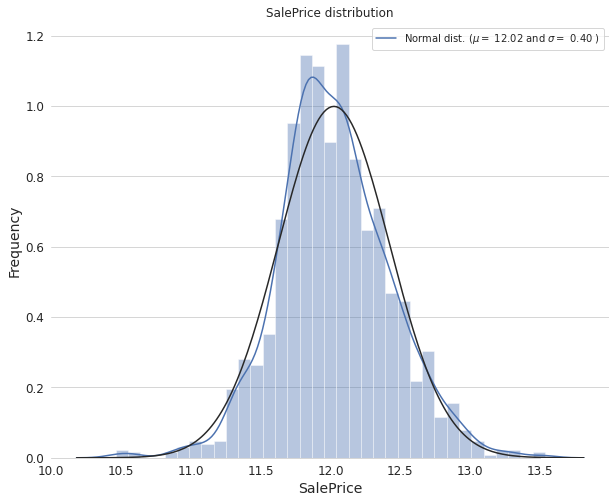

In [ ]:
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 8))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [ ]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [ ]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2917, 79)

### Fill in Missing Values

In [ ]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
df_miss = pd.DataFrame(df_miss, columns=['Attributes', 'Missing Percentage'])
print('Percent of missing data:')
df_miss[df_miss['Missing Percentage']>0]             

Percent of missing data:


Attributes  Missing Percentage
0         PoolQC              99.690
1    MiscFeature              96.400
2          Alley              93.210
3          Fence              80.430
4    FireplaceQu              48.680
5    LotFrontage              16.660
6    GarageYrBlt               5.450
7   GarageFinish               5.450
8     GarageQual               5.450
9     GarageCond               5.450
10    GarageType               5.380
11      BsmtCond               2.810
12  BsmtExposure               2.810
13      BsmtQual               2.780
14  BsmtFinType2               2.740
15  BsmtFinType1               2.710
16    MasVnrType               0.820
17    MasVnrArea               0.790
18      MSZoning               0.140
19     Utilities               0.070
20  BsmtFullBath               0.070
21  BsmtHalfBath               0.070
22    Functional               0.070
23   Exterior1st               0.030
24   Exterior2nd               0.030
25    BsmtFinSF1               0.030
26    BsmtFinSF2               0.030
27     BsmtUnfSF               0.030
28   TotalBsmtSF               0.030
29    Electrical               0.030
30   KitchenQual               0.030
31    GarageCars               0.030
32    GarageArea               0.030
33      SaleType               0.030

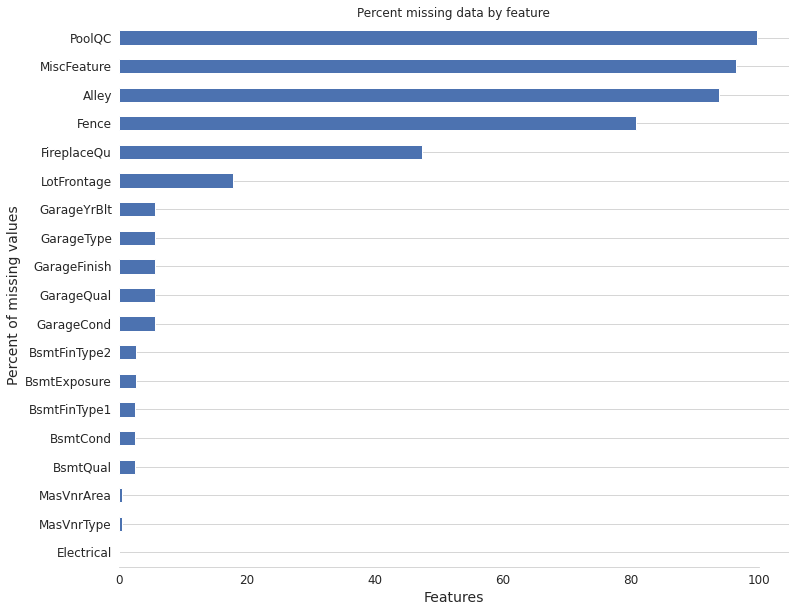

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.barh(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

We can now move through each of the features above and impute the missing values for each of them.

In [ ]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [ ]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)

In [ ]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

There are no missing values anymore!
### Fix Skewed Features

In [ ]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

In [ ]:
len(numeric)

33

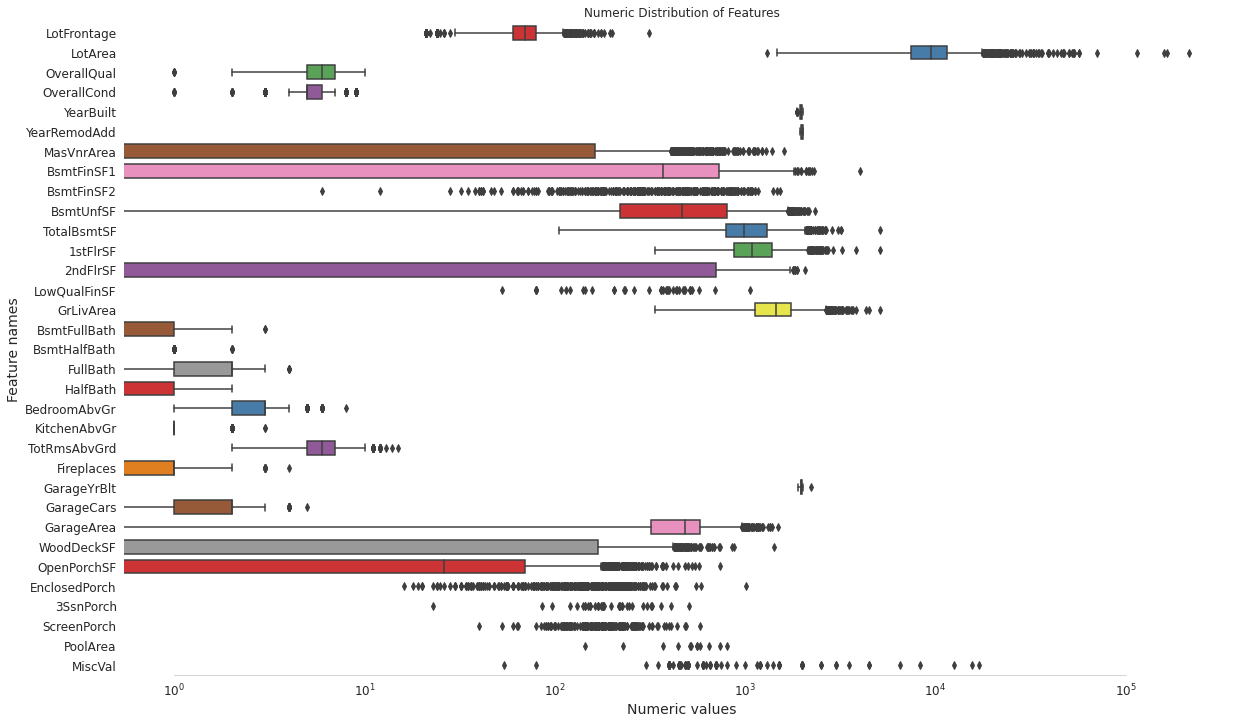

In [ ]:
# Create box plots for all numeric features
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(20, 12))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1", width = 0.7)
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [ ]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal         21.940
PoolArea        17.689
LotArea         13.109
LowQualFinSF    12.085
3SsnPorch       11.372
KitchenAbvGr     4.301
BsmtFinSF2       4.145
EnclosedPorch    4.002
ScreenPorch      3.945
BsmtHalfBath     3.930
dtype: float64

In [ ]:
# Normalize skewed features
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

In [ ]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(20, 12))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1", width = 0.7)
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

All the features look fairly normally distributed now.
## Feature Creation
Let's help our models out by creating a few features based on our intuition about the dataset, e.g. total area of floors, bathrooms and porch area of each house.

In [ ]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


## Feature transformations
Let's create more features by calculating the log and square transformations of our numerical features. We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2 is a predictor of the SalePrice.

In [ ]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)

In [ ]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_features = squares(all_features, squared_features)

## Encode categorical features
Numerically encode categorical features because most models can only handle numerical features.

In [ ]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [ ]:
all_features.head()

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0       18.145   13.833            7        3.992       2003          2003   
1       20.674   14.118            6        6.000       1976          1976   
2       18.668   14.477            7        3.992       2001          2002   
3       17.250   14.106            7        3.992       1915          1970   
4       21.314   15.022            8        3.992       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0      19.433     144.118       0.000     29.991      422.488     5.939   
1      54.598     181.719       0.000     44.135      593.888     6.235   
2      17.769     110.441       0.000     56.897      450.080     5.994   
3      54.598      61.795       0.000     64.809      378.854     6.028   
4      25.404     136.625       0.000     61.166      545.310     6.161   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  1025.652         0.000      8.354         0.993         0.000         2   
1   665.142         0.000      7.975         0.000         0.711         2   
2  1040.521         0.000      8.408         0.993         0.000         2   
3   904.477         0.000      8.359         0.993         0.000         1   
4  1273.024         0.000      8.669         0.993         0.000         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0     1.069             3         0.751         2.262       0.000   
1     0.000             3         0.751         1.997       0.903   
2     1.069             3         0.751         1.997       0.903   
3     0.000             3         0.751         2.137       0.903   
4     1.069             4         0.751         2.374       0.903   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0     2003.000       2.000     548.000       0.000       12.080   
1     1976.000       2.000     460.000      56.184        0.000   
2     2001.000       2.000     608.000       0.000        9.901   
3     1998.000       3.000     642.000       0.000        8.966   
4     2000.000       3.000     836.000      42.246       14.272   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  BsmtFinType1_Unf  \
0          0.000      0.000        0.000     0.000    0.000                 0   
1          0.000      0.000        0.000     0.000    0.000                 0   
2          0.000      0.000        0.000     0.000    0.000                 0   
3         16.021      0.000        0.000     0.000    0.000                 0   
4          0.000      0.000        0.000     0.000    0.000                 0   

   HasWoodDeck  HasOpenPorch  HasEnclosedPorch  Has3SsnPorch  HasScreenPorch  \
0            1             0                 1             1               1   
1            0             1                 1             1               1   
2            1             0                 1             1               1   
3            1             0                 0             1               1   
4            0             0                 1             1               1   

   YearsSinceRemodel  Total_Home_Quality  TotalSF  YrBltAndRemod  \
0                  5              10.992 1454.079           4006   
1                 31              12.000  600.123           3952   
2                  6              10.992 1496.595           4003   
3                 36              10.992 1289.359           3885   
4                  8              11.992 1824.495           4000   

   Total_sqr_footage  Total_Bathrooms  Total_porch_sf  haspool  has2ndfloor  \
0           1175.708            3.528          12.080        0            1   
1            187.954            2.355          56.184        0            1   
2           1156.956            3.528           9.901        0            1   
3            972.300            1.993          24.987        0            1   
4           1415.810    

In [ ]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]

## Recreate Train and Test sets

In [ ]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

Visualize some of the features we're going to train our models on.

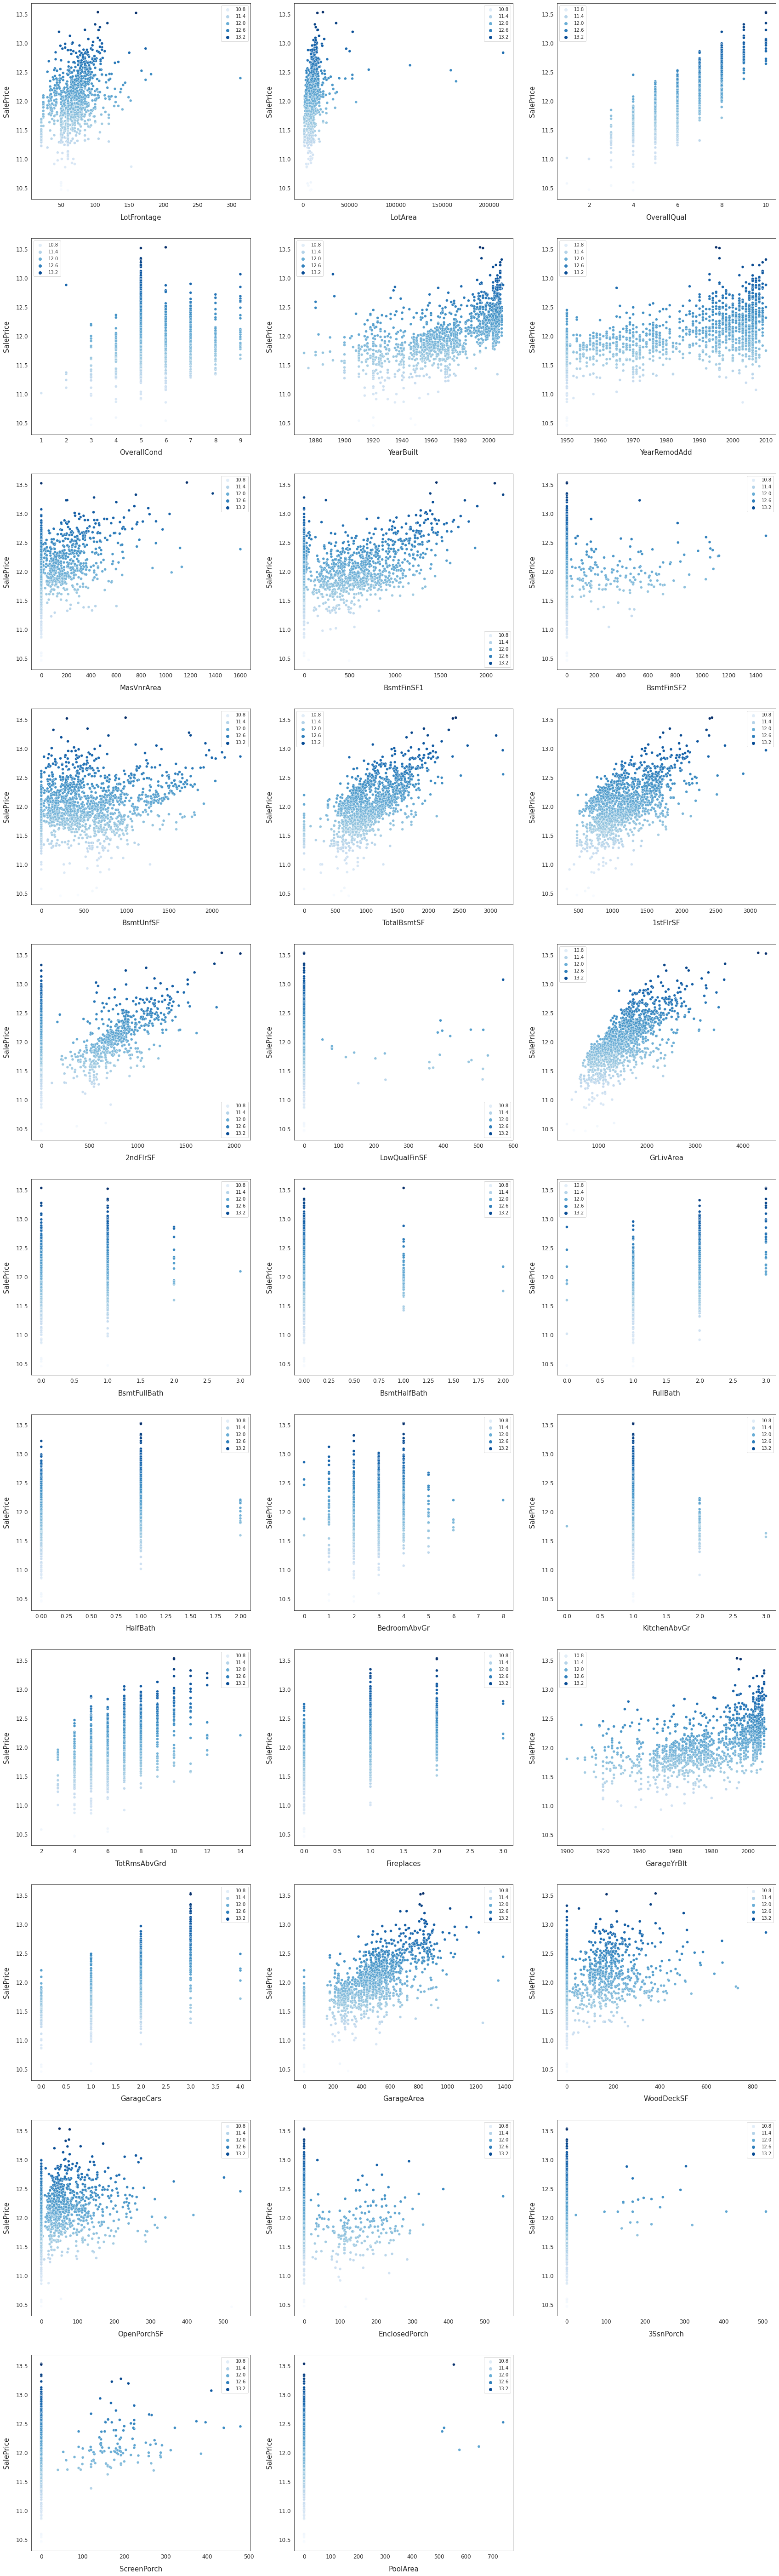

In [ ]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=4)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

## Train a model
####Key features of the model training process:
* Cross Validation: Using 12-fold cross-validation
* Models: On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
* Stacking: In addition, I trained a meta StackingCVRegressor optimized using xgboost
* Blending: All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

In [ ]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

## Setup cross validation and define error metrics

In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Setup Models

In [ ]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

### Stacking Regressors
Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor. The <code>StackingCVRegressor</code> extends the standard stacking algorithm (implemented as <code>StackingRegressor</code>) using out-of-fold predictions to prepare the input data for the level-2 regressor.

In the standard stacking procedure, the first-level regressors are fit to the same training set that is used prepare the inputs for the second-level regressor, which may lead to overfitting. The <code>StackingCVRegressor</code>, however, uses the concept of out-of-fold predictions: the dataset is split into k folds, and in k successive rounds, k-1 folds are used to fit the first level regressor. In each round, the first-level regressors are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level regressor. After the training of the <code>StackingCVRegressor</code>, the first-level regressors are fit to the entire dataset for optimal prediciton.

In [ ]:
from IPython.display import Image
Image('images/stacking_cv_regressor_overview.png')

## Train models
Get cross validation scores for each model.

In [ ]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1179 (0.0092)


In [ ]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.1389 (0.0093)


In [ ]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1103 (0.0100)


In [ ]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1115 (0.0084)


In [ ]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1391 (0.0097)


In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1134 (0.0099)


In [ ]:
scores  

{'gbr': (0.11343295820087769, 0.009923563973525144),
 'lgb': (0.1179223784390433, 0.00917005631782148),
 'rf': (0.13905491427281605, 0.009738248216889837),
 'ridge': (0.111454730221452, 0.008384097318687122),
 'svr': (0.11034173232809659, 0.009966167499527936),
 'xgb': (0.13887550920409888, 0.009326181057059062)}

In [ ]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

stack_gen


In [ ]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [ ]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost


In [ ]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [ ]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [ ]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [ ]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


## Blend Models and get training prediction

In [ ]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [ ]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07590405640897245


## Identify the Best performing Model

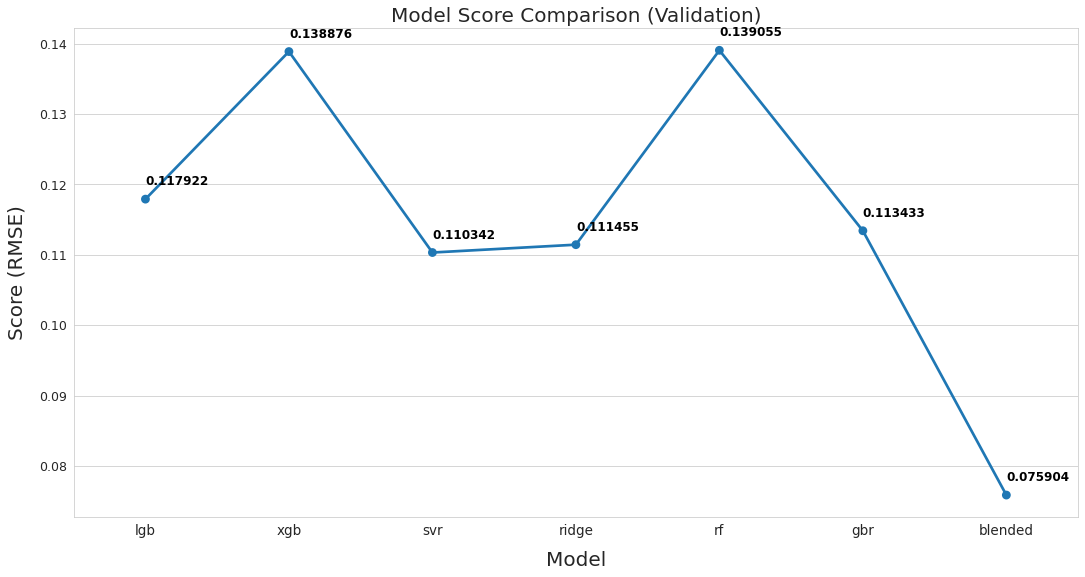

In [ ]:
# Plot the predictions for each model
sns.set_style("whitegrid")
fig = plt.figure(figsize=(18, 9))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Model Score Comparison (Validation)', size=20)

plt.show()

In [ ]:
# Read in sample_submission dataframe
submission = pd.read_csv("sample_submission.csv")
submission.shape

(1459, 2)

In [ ]:
submission.head(5)

Id  SalePrice
0  1461 169277.052
1  1462 187758.394
2  1463 183583.684
3  1464 179317.478
4  1465 150730.080

In [ ]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(np.expm1(blended_predictions(X_test)))

In [ ]:
# Fix outleir predictions
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
sub = pd.read_csv("submission_regression1.csv")
sub.head(5)

Id  SalePrice
0  1461 122732.000
1  1462 160375.000
2  1463 183505.000
3  1464 195353.000
4  1465 187899.000

In [ ]:
sub.shape

(1459, 2)

# Improvements (Next Workshop):
1. Data Pre-processing: Better Missing Values Treatment
2. Data Pre-processing: Better Outlier Treatment
3. Feature Engineering: Create Better Features
4. Feature Engineering: Test Feature Importance > Drop insignigicant features
5. Model Building: Hyperparameter Tuning to reduce overfitting